In [ ]:
!pip install --upgrade --upgrade-strategy eager ultralytics

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
import yaml
import json
import torch
from PIL import Image
from IPython.display import display
from ultralytics import YOLO
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch.nn.modules.conv')

# --- Configuration ---
INPUT_BASE_PATH = '/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/'
YOLO_BASE_PATH = '/kaggle/working/SARscope_YOLO/'
YOLO_DATA_YAML_PATH = '/kaggle/working/dataset.yaml'

SPLITS = {
    'train': os.path.join(INPUT_BASE_PATH, 'train'),
    'valid': os.path.join(INPUT_BASE_PATH, 'valid'),
    'test': os.path.join(INPUT_BASE_PATH, 'test')
}
YOLO_CLASS_ID = 0

# --- CRITICAL PRE-FLIGHT CHECK ---
if not os.path.exists(INPUT_BASE_PATH):
    print("\n" + "="*50)
    print("ERROR: INPUT DATA NOT FOUND!")
    print(f"The path '{INPUT_BASE_PATH}' does not exist.")
    print("Please make sure you have attached the 'sarscope-unveiling-the-maritime-landscape' dataset.")
    print("="*50)
    raise FileNotFoundError("Input dataset not found. Please follow the instructions in Cell 0.")
else:
    print(f"Input dataset found at: {INPUT_BASE_PATH}")

device_count = torch.cuda.device_count()
print(f"Configuration loaded. Found {device_count} GPUs.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Input dataset found at: /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/
Configuration loaded. Found 2 GPUs.


In [2]:
print("--- Starting Data Preparation: Converting COCO to YOLO format ---")
os.makedirs(YOLO_BASE_PATH, exist_ok=True)

def prepare_yolo_data_robust(source_path, yolo_base_path, split_name):
    print(f"\n--- Preparing '{split_name}' split ---")
    image_dst_path = os.path.join(yolo_base_path, split_name, 'images')
    label_dst_path = os.path.join(yolo_base_path, split_name, 'labels')
    os.makedirs(image_dst_path, exist_ok=True)
    os.makedirs(label_dst_path, exist_ok=True)

    # Copy all images
    image_src_paths = glob.glob(os.path.join(source_path, "*.jpg"))
    if not image_src_paths:
        print(f"WARNING: No .jpg images found in {source_path}.")
        return
    for src_path in image_src_paths:
        shutil.copy(src_path, image_dst_path)
    print(f"Copied {len(image_src_paths)} images.")

    # Convert COCO annotations
    json_path = os.path.join(source_path, '_annotations.coco.json')
    if not os.path.exists(json_path):
        print(f"WARNING: No annotation file found for '{split_name}'.")
        return

    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    images_info = {img['id']: img for img in coco_data['images']}
    
    annotations_processed = 0
    for ann in coco_data.get('annotations', []):
        img_id = ann['image_id']
        if img_id not in images_info: continue
        img_info = images_info[img_id]
        img_w, img_h = img_info['width'], img_info['height']
        xmin, ymin, w, h = ann['bbox']
        cx, cy = (xmin + w / 2) / img_w, (ymin + h / 2) / img_h
        w_norm, h_norm = w / img_w, h / img_h
        yolo_line = f"{YOLO_CLASS_ID} {cx:.6f} {cy:.6f} {w_norm:.6f} {h_norm:.6f}\n"
        file_name_base = os.path.splitext(img_info['file_name'])[0]
        yolo_path = os.path.join(label_dst_path, f"{file_name_base}.txt")
        with open(yolo_path, 'a') as f:
            f.write(yolo_line)
        annotations_processed += 1
    print(f"Processed {annotations_processed} annotations.")

# Run preparation for all splits
for split, path in SPLITS.items():
    prepare_yolo_data_robust(path, YOLO_BASE_PATH, split)

print("\nData preparation complete.")

--- Starting Data Preparation: Converting COCO to YOLO format ---

--- Preparing 'train' split ---
Copied 4717 images.
Processed 13640 annotations.

--- Preparing 'valid' split ---
Copied 1346 images.
Processed 3781 annotations.

--- Preparing 'test' split ---
Copied 672 images.
Processed 2014 annotations.

Data preparation complete.


In [3]:
# --- Step 1: Create dataset.yaml configuration file ---
config_file_content = f'''
# YOLOv11 SARscope configuration
path: {YOLO_BASE_PATH} 
train: train/images
val: valid/images
test: test/images

# Class details
nc: 1
names: ['ship']
'''
with open(YOLO_DATA_YAML_PATH, 'w') as f:
    f.write(config_file_content)
print(f"YOLOv11 configuration file created at: {YOLO_DATA_YAML_PATH}")

# --- Step 2: Load YOLOv11 Medium Model ---
model = YOLO('yolo11m.pt')
model_name = "YOLOv11m"
print("Successfully loaded yolo11m.pt.")

# --- Step 3: Start Training ---
print("\n" + "="*50)
print(f"STARTING {model_name} MODEL TRAINING ON 2 GPUS...")
print("="*50)

results = model.train(
    data=YOLO_DATA_YAML_PATH, 
    epochs=30, 
    imgsz=640, 
    device=[0, 1],
    project='runs_detect', 
    name=f'SARscope_{model_name}'
)
print("\nTraining complete.")

# --- Step 4: Export to ONNX ---
print("\nExporting the best trained model to ONNX format...")
model.export(format='onnx') 
print("Model successfully exported to ONNX format.")

YOLOv11 configuration file created at: /kaggle/working/dataset.yaml
Successfully loaded yolo11m.pt.

STARTING YOLOv11m MODEL TRAINING ON 2 GPUS...
Ultralytics 8.3.217 🚀 Python-3.11.13 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mi

--- Starting Test Inference and Visualization ---
Attempting to load best weights from the known DDP path: /kaggle/working/runs_detect/SARscope_YOLOv11m/weights/best.pt
Best weights loaded successfully.

Loading ground truth annotations for the test set...
Ground truth annotations loaded.

Running inference on the first 4 test images...

0: 640x640 8 ships, 33.0ms
1: 640x640 7 ships, 33.0ms
2: 640x640 6 ships, 33.0ms
3: 640x640 3 ships, 33.0ms
Speed: 1.9ms preprocess, 33.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

Displaying comparison: Ground Truth vs. Prediction...

--- Comparison for Image 1/4 ---


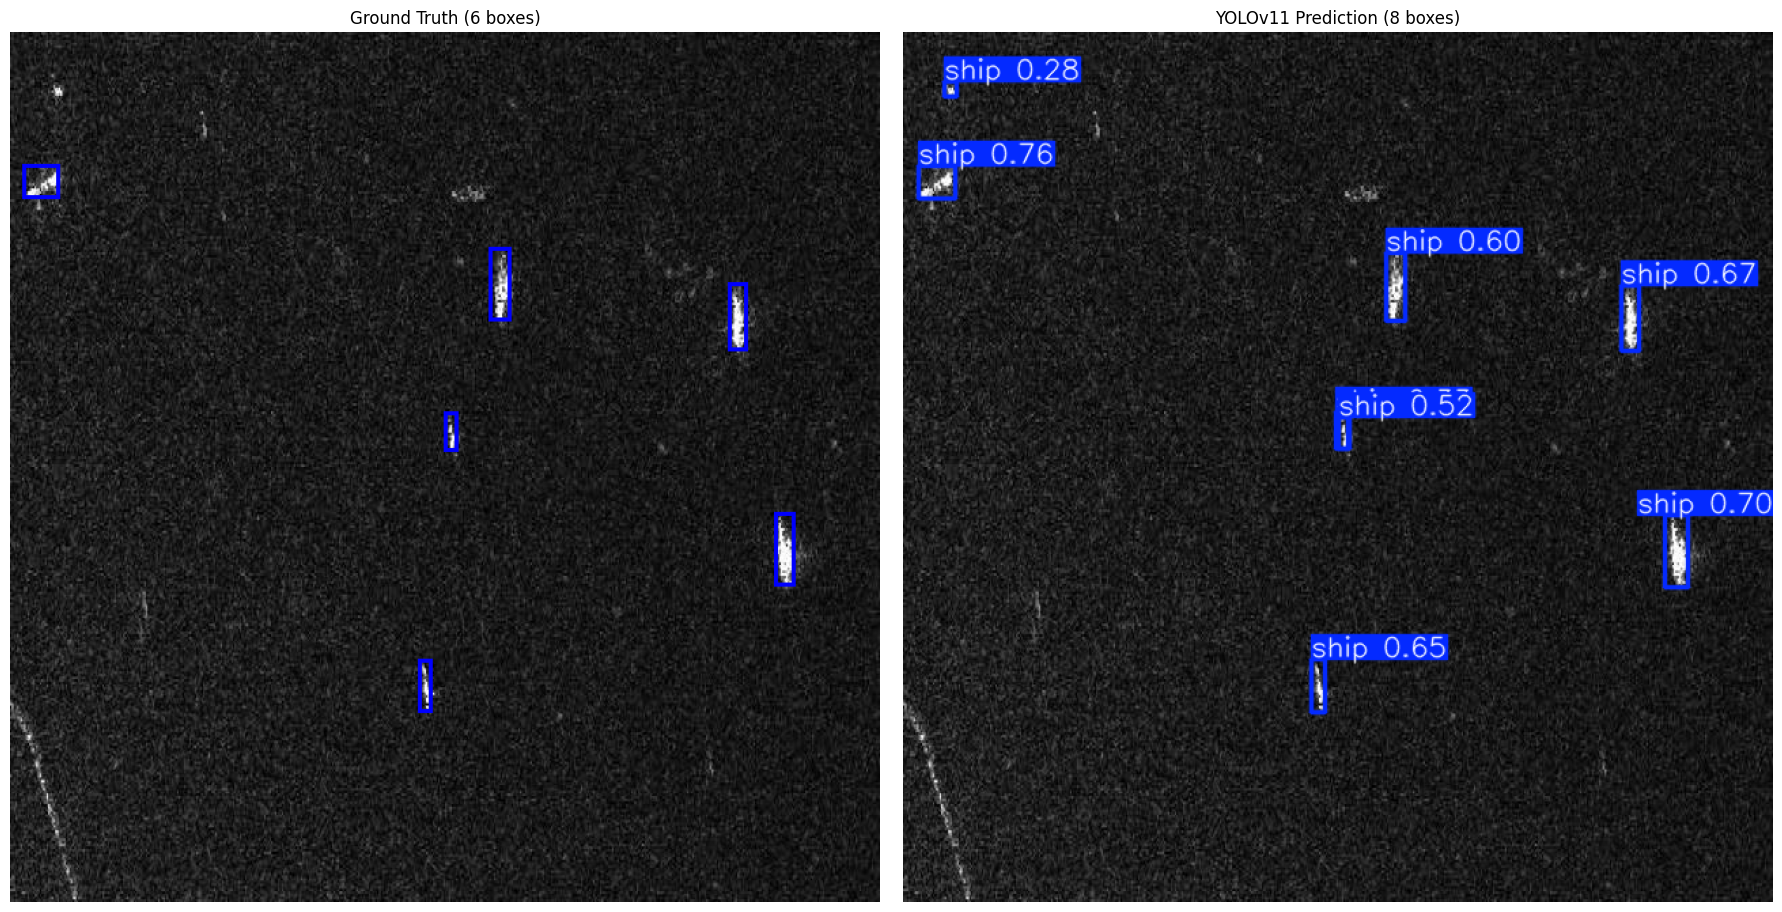


--- Comparison for Image 2/4 ---


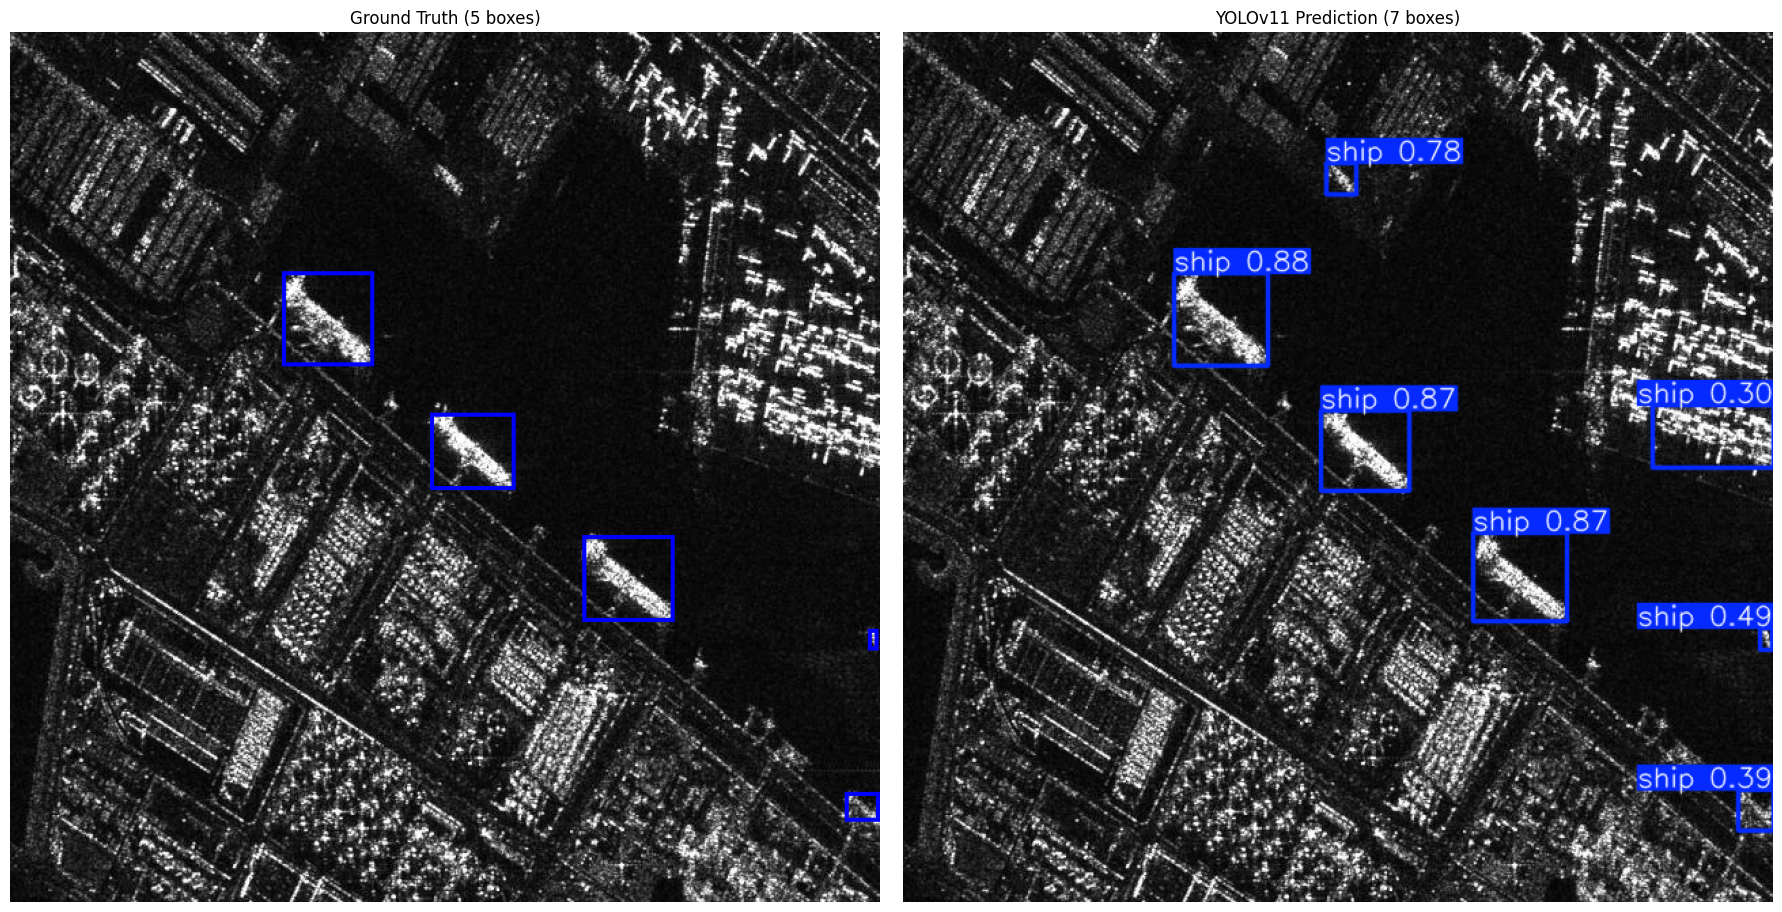


--- Comparison for Image 3/4 ---


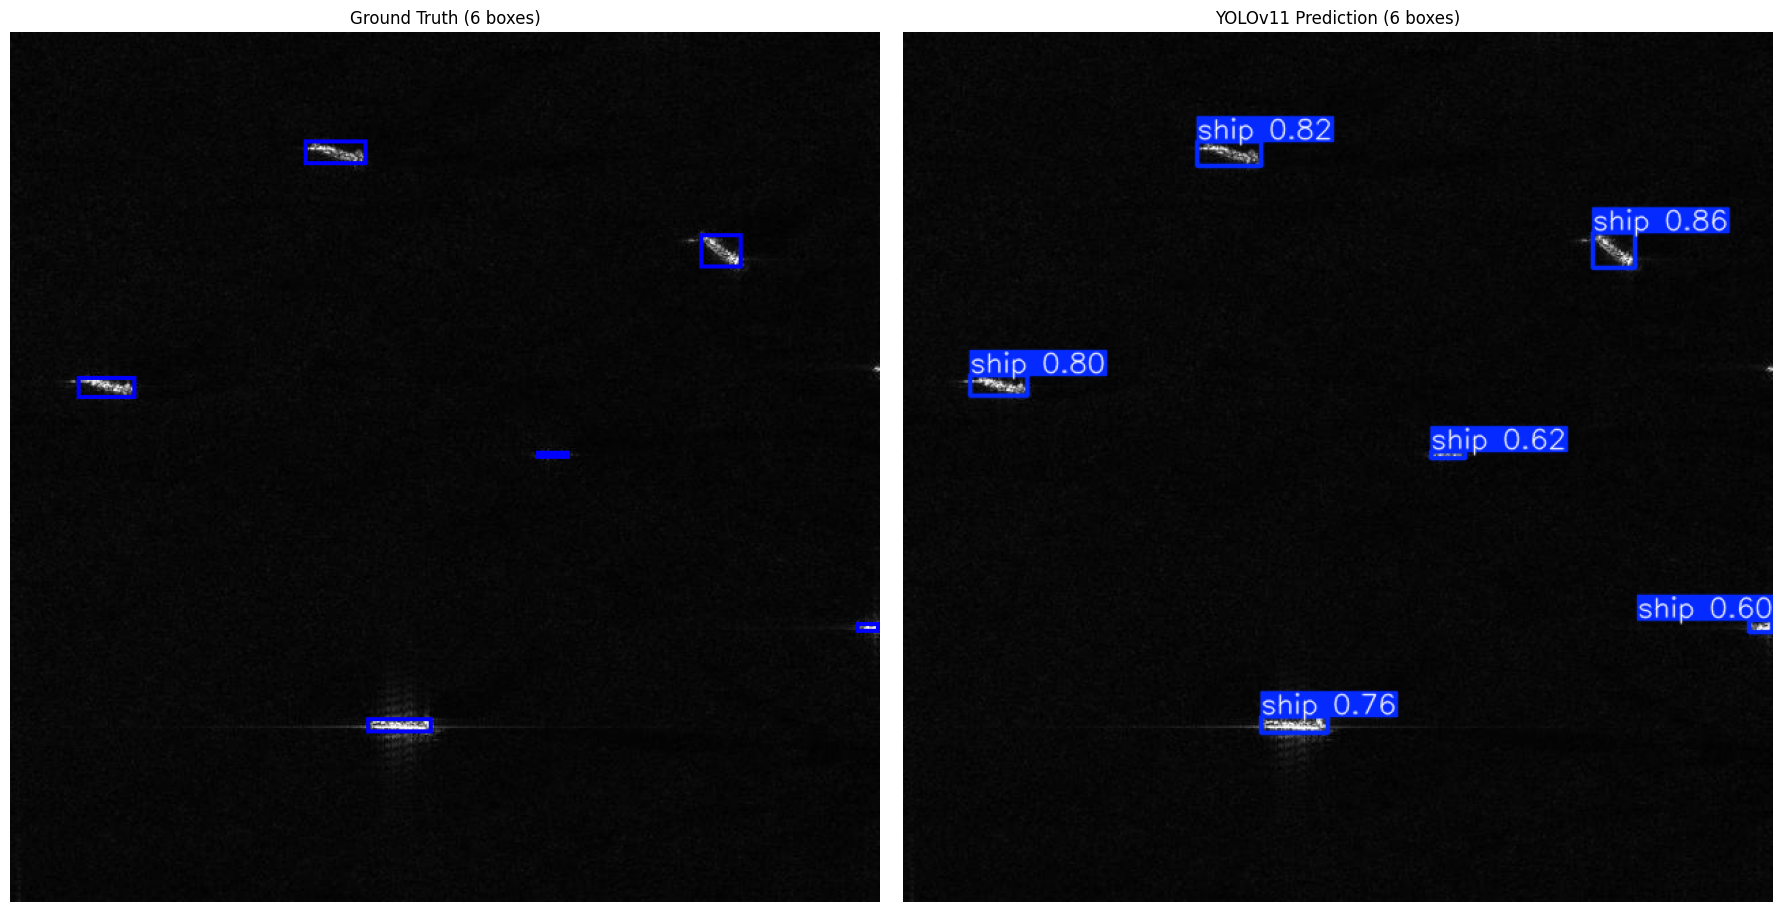


--- Comparison for Image 4/4 ---


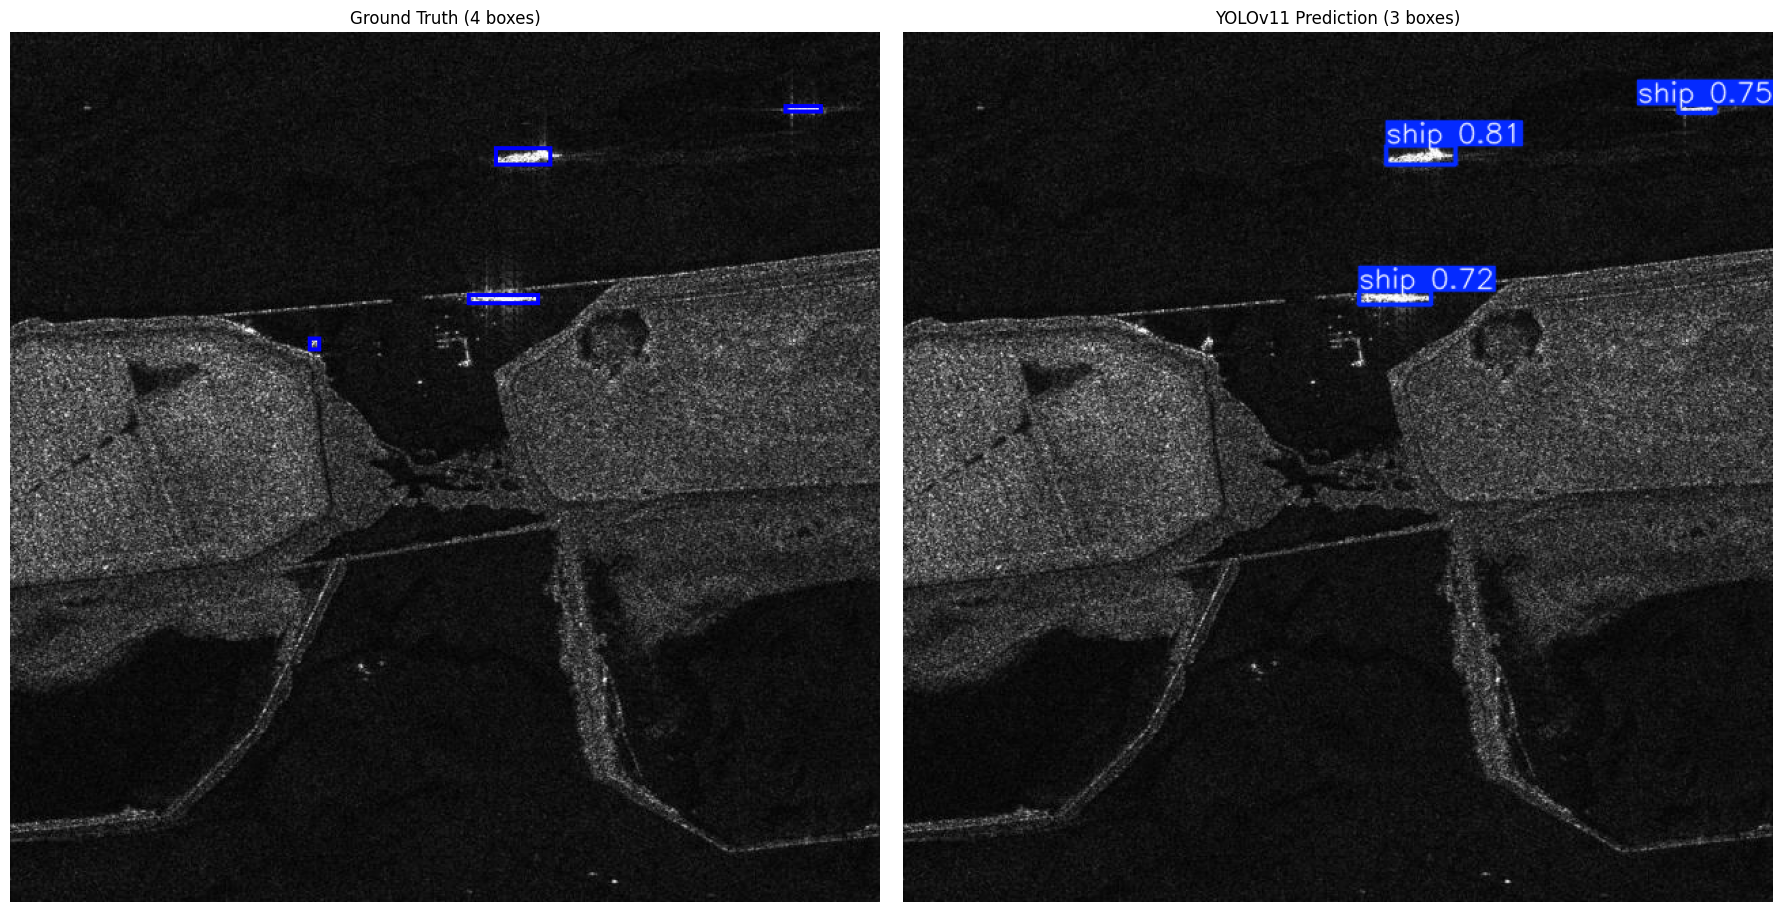



Test inference and visualization complete!


In [6]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

print("--- Starting Test Inference and Visualization ---")

# --- Step 1: Load the best trained weights ---
try:
    # The 'model_name' variable must be available from Cell 3.
    run_name = f'SARscope_{model_name}'
    project_dir = 'runs_detect'
    BEST_WEIGHTS_PATH = f'/kaggle/working/{project_dir}/{run_name}/weights/best.pt'
    
    print(f"Attempting to load best weights from the known DDP path: {BEST_WEIGHTS_PATH}")
    
    if not os.path.exists(BEST_WEIGHTS_PATH):
        raise FileNotFoundError(f"The weights file could not be found. Please check the directory: /kaggle/working/{project_dir}/{run_name}/")
        
    test_model = YOLO(BEST_WEIGHTS_PATH)
    print("Best weights loaded successfully.")

except Exception as e:
    print(f"ERROR: Could not load best weights. Error: {e}")
    if 'model_name' not in locals():
        print("Hint: The 'model_name' variable was not found. Please run Cell 3 to define it before running this cell.")
    raise

# --- Step 2: Load Ground Truth Annotations for Comparison ---
print("\nLoading ground truth annotations for the test set...")
test_ann_path = os.path.join(SPLITS['test'], '_annotations.coco.json')
with open(test_ann_path, 'r') as f:
    coco_gt = json.load(f)

# Create mappings for easy lookup: filename -> image_id -> bboxes
images_info = {img['file_name']: img for img in coco_gt['images']}
gt_annotations = {}
for ann in coco_gt.get('annotations', []):
    img_id = ann['image_id']
    if img_id not in gt_annotations:
        gt_annotations[img_id] = []
    # COCO format is [xmin, ymin, width, height]
    gt_annotations[img_id].append(ann['bbox'])
print("Ground truth annotations loaded.")


def draw_ground_truth_boxes(image_path, bboxes):
    """Draws ground truth bounding boxes on an image."""
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    
    for bbox in bboxes:
        xmin, ymin, w, h = bbox
        xmax, ymax = xmin + w, ymin + h
        # Draw rectangle with a distinct color (blue)
        draw.rectangle([xmin, ymin, xmax, ymax], outline="blue", width=3)
        
    return img

# --- Step 3: Run inference on test images ---
test_image_paths = glob.glob(os.path.join(SPLITS['test'], "*.jpg"))
num_samples = 4
print(f"\nRunning inference on the first {num_samples} test images...")
inference_results = test_model(test_image_paths[:num_samples], stream=False)

# --- Step 4: Display Side-by-Side Comparison ---
print("\nDisplaying comparison: Ground Truth vs. Prediction...")
for i in range(num_samples):
    print(f"\n--- Comparison for Image {i+1}/{num_samples} ---")
    
    # --- Prepare Ground Truth Image ---
    current_image_path = inference_results[i].path
    img_filename = os.path.basename(current_image_path)
    
    # Find the corresponding ground truth bboxes
    ground_truth_bboxes = []
    if img_filename in images_info:
        img_id = images_info[img_filename]['id']
        if img_id in gt_annotations:
            ground_truth_bboxes = gt_annotations[img_id]
            
    # Draw the boxes
    ground_truth_image = draw_ground_truth_boxes(current_image_path, ground_truth_bboxes)

    # --- Prepare Predicted Image ---
    predicted_image_bgr = inference_results[i].plot() # Returns a BGR numpy array
    predicted_image_rgb = Image.fromarray(predicted_image_bgr[..., ::-1]) # Convert to RGB PIL Image

    # --- Plot Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    
    axes[0].imshow(ground_truth_image)
    axes[0].set_title(f'Ground Truth ({len(ground_truth_bboxes)} boxes)')
    axes[0].axis('off')
    
    axes[1].imshow(predicted_image_rgb)
    axes[1].set_title(f'YOLOv11 Prediction ({len(inference_results[i].boxes)} boxes)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n\nTest inference and visualization complete!")